# ANÁLISIS PREDICTIVO

A continuación se presenta el análisis predictivo. Realizamos una regresión lineal sobre los salarios en el tiempo, y obtuvimos predicciones salariales para 2025

In [1]:
# IMPORTS
import sys
import json
from pathlib import Path
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# SET PROJECT FOLDER
project_folder = Path.cwd().parent.parent

# LOAD LOCAL_SETUP_CONFIG FILE
config_path = project_folder / "local_setup_config.json"
if config_path.exists():
    with open(config_path, "r", encoding="utf-8") as file:
        local_config  = json.load(file)
    print('Local configuration file loaded succesfully')
else:
    raise FileNotFoundError(f"Error: {config_path} not found")

# set run_local
run_local = local_config["run_local"]

# MODULE PATHS
scripts_folder = project_folder / "Scripts"
sys.path.append(str(scripts_folder))

# MODULE IMPORTS
import test_script
import load_database

# LOAD DATABASE
load_database.load_db(project_folder)

# DATABASE CONNECTION
if run_local:
    linkedindatabase_path = project_folder / "database" / "linkedindatabase.db"
else:
    linkedindatabase_path = project_folder / "database" / "linkedindatabase.db"

if linkedindatabase_path.exists():
    conn = sqlite3.connect(linkedindatabase_path)
    print("Opened database successfully")
else:
    raise FileNotFoundError(f"Error: {linkedindatabase_path} not found")

Local configuration file loaded succesfully


Project folder set to C:\Users\Sarah\Code\ProyectoABD for load_database.py
You're running on local
Database already loaded!
Opened database successfully


In [2]:
#DATAFRAME CREATION

#numerical data
df_num = pd.read_sql('SELECT * FROM clean_numerical_postings', conn)

df_num = df_num[df_num['max_salary'] <= 10000000]
df_num = df_num[df_num['min_salary'] <= 10000000]
df_num = df_num[df_num['normalized_salary'] <= 10000000]

df_num = df_num[df_num['max_salary'] > 100]
df_num = df_num[df_num['min_salary'] > 100]
df_num = df_num[df_num['normalized_salary'] > 100]

#postings
df_postings = pd.read_sql('SELECT * FROM postings', conn)

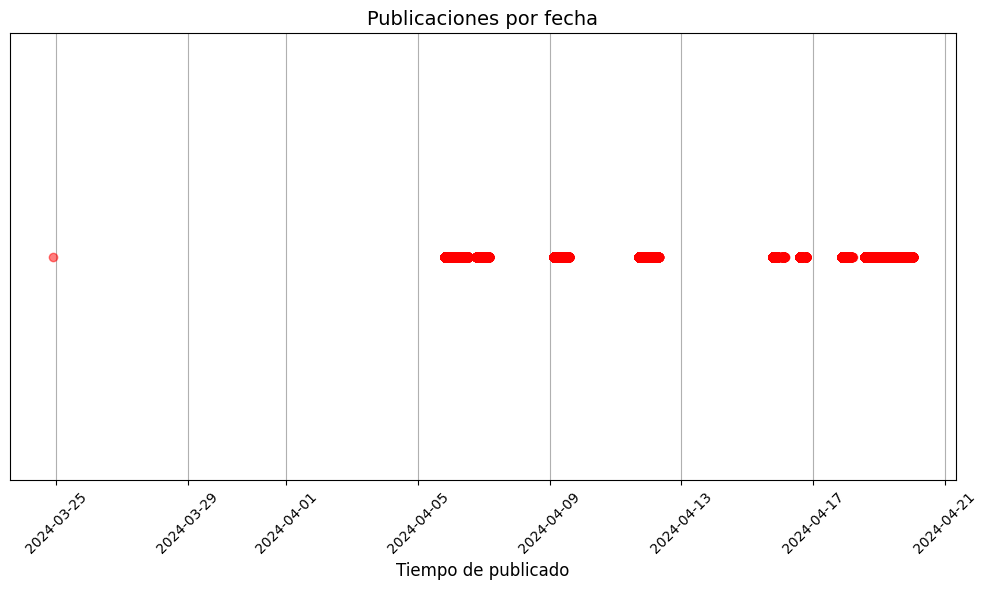

In [ ]:
# Convert 'listed_time' from milliseconds to seconds and then to datetime
df_listed_time_unix = df_postings['listed_time'].apply(lambda x: x/1000)
df_listed_time = pd.to_datetime(df_listed_time_unix, unit='s')

# Plotting the timeline
plt.figure(figsize=(10, 6))
plt.plot(df_listed_time, [1] * len(df_postings), 'ro', alpha=0.5)  # Plot points at y=1 for each entry
plt.yticks([])  # Remove y-axis ticks as it's not necessary for this plot
plt.xlabel('Tiempo de publicación', fontsize=12)
plt.title('Publicaciones por fecha', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

# Show the graph
plt.show()


C:\Users\Sarah\AppData\Local\Temp\ipykernel_16580\4287404388.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['listed_time'] = df_clean['listed_time'].apply(lambda x: x / 1000)  # Convert to seconds
C:\Users\Sarah\AppData\Local\Temp\ipykernel_16580\4287404388.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['listed_time'] = pd.to_datetime(df_clean['listed_time'], unit='s')
c:\Users\Sarah\Code\ProyectoABD\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does no

Salario promedio proyectado para Mayo 2024: 181436.13


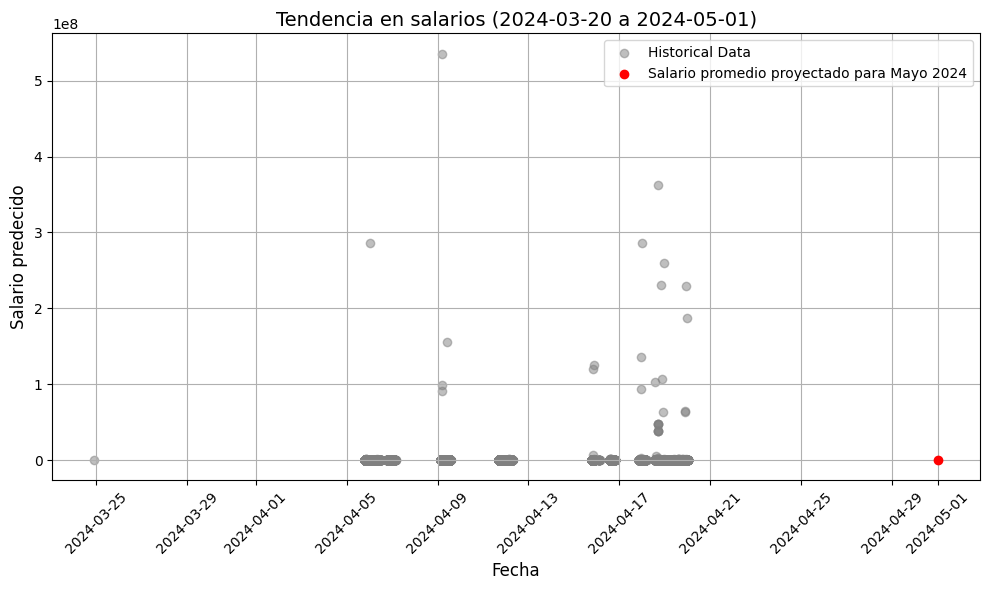

In [ ]:

# Apply dropna() to the entire dataframe to ensure X and y are aligned
df_clean = df_postings.dropna(subset=['listed_time', 'normalized_salary'])

# Convert 'listed_time' from milliseconds to seconds (by dividing by 1000)
df_clean['listed_time'] = df_clean['listed_time'].apply(lambda x: x / 1000)  # Convert to seconds

# Filter the data to only include listings between 2024-03-20 and 2024-04-20
df_clean['listed_time'] = pd.to_datetime(df_clean['listed_time'], unit='s')
df_clean = df_clean[(df_clean['listed_time'] >= pd.to_datetime('2024-03-20')) & 
                    (df_clean['listed_time'] <= pd.to_datetime('2024-04-20'))]

# Prepare the features (independent variables) and target (dependent variable)
X = df_clean[['listed_time']].astype(np.int64) // 10**9  # Convert to Unix timestamp in seconds
y = df_clean['normalized_salary']

# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the data
model.fit(X, y)

# Predict for May 2024 (using the Unix timestamp for May 1, 2024)
may_2024_timestamp = pd.to_datetime('2024-05-01').timestamp()

# Make a prediction for May 2024
predicted_salary_may = model.predict(np.array([[may_2024_timestamp]]))

# Print the prediction for May 2024
print(f"Salario promedio proyectado para Mayo 2024: {predicted_salary_may[0]:.2f}")

# Plotting the salary trend over time (training data and prediction for May 2024)
plt.figure(figsize=(10, 6))

# Plot the historical data (March 20, 2024 - April 20, 2024)
plt.scatter(df_clean['listed_time'], y, color='grey', alpha=0.5, label='Datos Históricos')

# Plot the predicted salary for May 2024 (as a point on the timeline)
plt.scatter(pd.to_datetime('2024-05-01'), predicted_salary_may, color='red', label='Salario promedio proyectado para Mayo 2024', zorder=5)

# Formatting the plot
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Salario predecido', fontsize=12)
plt.title('Tendencia en salarios (2024-03-20 a 2024-05-01)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the graph
plt.legend()
plt.show()
